<a href="https://colab.research.google.com/github/YaraElwakeel/Cuda_Vision_Lab-/blob/main/trial_session1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import optuna
import torch.optim as optim
from optuna.trial import TrialState

In [41]:
pip install optuna

In [55]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train = False,transform = transforms.ToTensor(), download = True )

In [56]:
n_imgs_train = len(train_dataset)
n_imgs_test = len(test_dataset)

In [57]:
print(f"# Images Train: {n_imgs_train}")
print(f"# Images Test:  {n_imgs_test}")

# Images Train: 60000
# Images Test:  10000


In [58]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 9


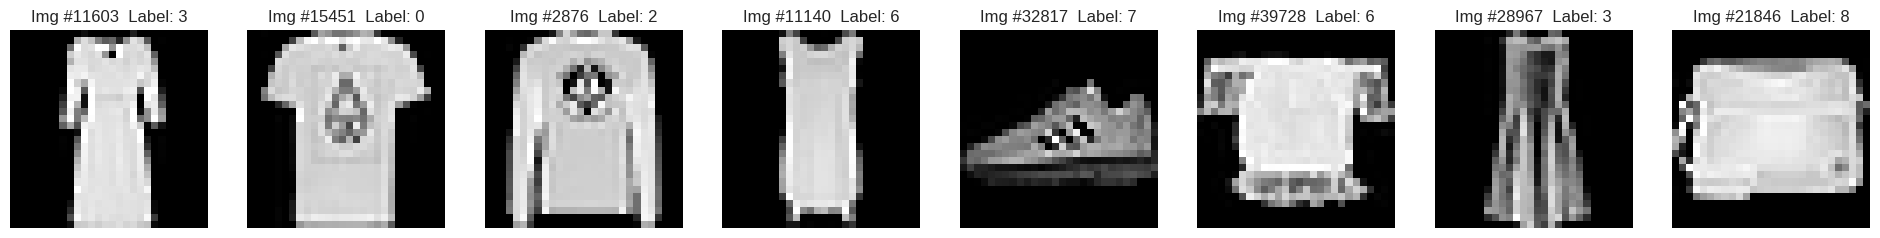

In [59]:
import matplotlib.pyplot as plt

N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(28,28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

In [60]:
BATCH_SIZE = 1024
train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [61]:

imgs, labels = next(iter(eval_loader))
print(f"{imgs.shape = }")
print(f"{labels.shape = }")

imgs.shape = torch.Size([1024, 1, 28, 28])
labels.shape = torch.Size([1024])


In [62]:
class Model(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=[128,64], output_dim=10,droupout_prob = 0.5):
        super().__init__()
        self.layers = nn.Sequential(
                # nn.Linear(in_features=input_dim, out_features=256),
                # # nn.Dropout(droupout_prob),
                # nn.ReLU(),
                nn.Linear(in_features=input_dim, out_features=hidden_dim[0]),
                # nn.Dropout(droupout_prob),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim[0], out_features=hidden_dim[1]),
                # nn.Dropout(droupout_prob),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim[1], out_features=output_dim)
            )

    def forward(self, x):
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred

In [63]:
NUM_EPOCHS = 10
LR = 3e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=784, hidden_dim=[256,128], output_dim=10)
print(model)
model = model.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [73]:
def train_per_epoch(model, train_loader, criterion, optimizer, device,epoch):
  correct = 0
  total = 0
  global loss_train_list, accuracy_train_list
  model.train()
  progress_bar = tqdm(train_loader, total=len(train_loader))

  for i, (imgs, labels) in enumerate(progress_bar):
      # using GPU
      imgs, labels = imgs.to(device), labels.to(device)
      # forward pass
      flattened_imgs = imgs.flatten(start_dim=1)
      preds = model(flattened_imgs)

      # computing error
      loss = criterion(preds, labels)
      loss_train_list.append(loss.item())

      # removing accumulated gradients
      optimizer.zero_grad()

      # backpropagating error to compute gradients
      loss.backward()

      # updating parameters
      optimizer.step()

      # Get predicted classes
      preds_class = torch.argmax(preds, dim=-1)

      # Count the number of correct predictions
      correct += (preds_class == labels).sum().item()

      # Total number of predictions
      total += labels.size(0)

      # Compute accuracy for the current batch
      accuracy = correct / total
      accuracy_train_list.append(accuracy)
      # Update the progress bar
      if(i % 10 == 0 or i == len(train_loader) - 1):
          progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}, accuracy {accuracy:.5f}")


def validate_per_epoch(model, val_loader, criterion, device):
  global loss_valid_list, accuracy_valid_list
  model.eval()
  with torch.no_grad():
      for i, (imgs, labels) in enumerate(val_loader):
          imgs , labels = imgs.to(device), labels.to(device)
          flattened_imgs = imgs.flatten(start_dim=1)
          model.eval()
          preds = model(flattened_imgs)
          # loss calculation
          loss = criterion(preds, labels)
          loss_valid_list.append(loss.item())
          # accuracy calculation
          pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
          cur_correct = len(torch.where(pred_labels == labels)[0])
          accuracy_per_batch = cur_correct / len(labels) * 100
          accuracy_valid_list.append(accuracy_per_batch)
          # n_correct = n_correct + cur_correct

      # accuracy = n_correct / len(test_dataset) * 100
      # print(f"Test accuracy: {round(accuracy,2)}%")



In [74]:
from tqdm import tqdm

loss_train_list = []
accuracy_train_list = []

loss_valid_list = []
accuracy_valid_list = []
for epoch in range(NUM_EPOCHS):
  train_per_epoch(model, train_loader, criterion, optimizer, device,epoch)
  validate_per_epoch(model, eval_loader, criterion, device)

Epoch 10 Iter 59: loss 0.30079, accuracy 0.87360: 100%|██████████| 59/59 [00:10<00:00,  5.71it/s]


In [27]:

# from tqdm import tqdm

# loss_list = []
# accuracy_list = []
# correct = 0
# total = 0
# for epoch in range(NUM_EPOCHS):
#     progress_bar = tqdm(train_loader, total=len(train_loader))
#     for i, (imgs, labels) in enumerate(progress_bar):
#         # using GPU
#         imgs, labels = imgs.to(device), labels.to(device)
#         model.train()
#         # forward pass
#         flattened_imgs = imgs.flatten(start_dim=1)
#         preds = model(flattened_imgs)

#         # computing error
#         loss = criterion(preds, labels)
#         loss_list.append(loss.item())

#         # removing accumulated gradients
#         optimizer.zero_grad()

#         # backpropagating error to compute gradients
#         loss.backward()

#         # updating parameters
#         optimizer.step()

#         # Get predicted classes
#         preds_class = torch.argmax(preds, dim=1)

#         # Count the number of correct predictions
#         correct += (preds_class == labels).sum().item()

#         # Total number of predictions
#         total += labels.size(0)

#         # Compute accuracy for the current batch
#         accuracy = correct / total
#         accuracy_list.append(accuracy)
#         # Update the progress bar
#         if(i % 10 == 0 or i == len(train_loader) - 1):
#             progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}, accuracy {accuracy:.5f}")


Epoch 10 Iter 59: loss 0.36753, accuracy 0.87535: 100%|██████████| 59/59 [00:09<00:00,  6.54it/s]


In [75]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

<ipython-input-36-d04cf6ad9d0d>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


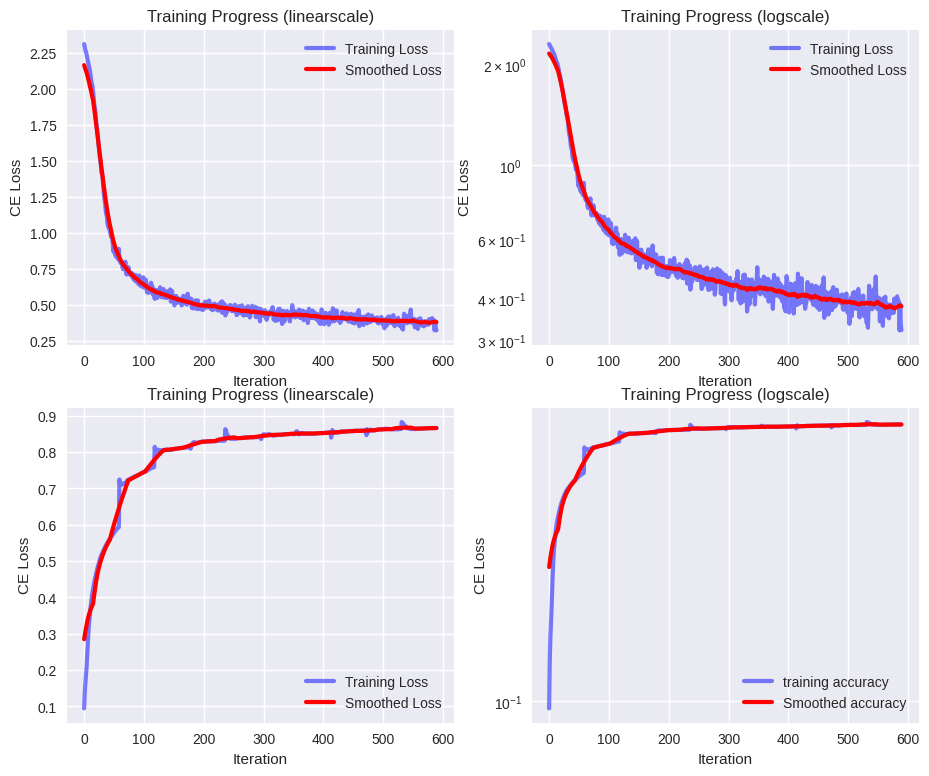

In [36]:
plt.style.use('seaborn')
fig, ax = plt.subplots(2,2)
fig.set_size_inches(11,9)

smooth_loss = smooth(loss_list, 31)
ax[0][0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0][0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0][0].legend(loc="best")
ax[0][0].set_xlabel("Iteration")
ax[0][0].set_ylabel("CE Loss")
ax[0][0].set_title("Training Progress (linearscale)")

ax[0][1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0][1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0][1].legend(loc="best")
ax[0][1].set_xlabel("Iteration")
ax[0][1].set_ylabel("CE Loss")
ax[0][1].set_yscale("log")
ax[0][1].set_title("Training Progress (logscale)")


smooth_accuracy = smooth(accuracy_list, 31)
ax[1][1].plot(accuracy_list, c="blue", label="training accuracy", linewidth=3, alpha=0.5)
ax[1][1].plot(smooth_accuracy, c="red", label="Smoothed accuracy", linewidth=3)
ax[1][1].legend(loc="best")
ax[1][1].set_xlabel("Iteration")
ax[1][1].set_ylabel("CE Loss")
ax[1][1].set_yscale("log")
ax[1][1].set_title("Training Progress (logscale)")

ax[1][0].plot(accuracy_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1][0].plot(smooth_accuracy, c="red", label="Smoothed Loss", linewidth=3)
ax[1][0].legend(loc="best")
ax[1][0].set_xlabel("Iteration")
ax[1][0].set_ylabel("CE Loss")
ax[1][0].set_title("Training Progress (linearscale)")
plt.show()

100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Test accuracy: 85.38%


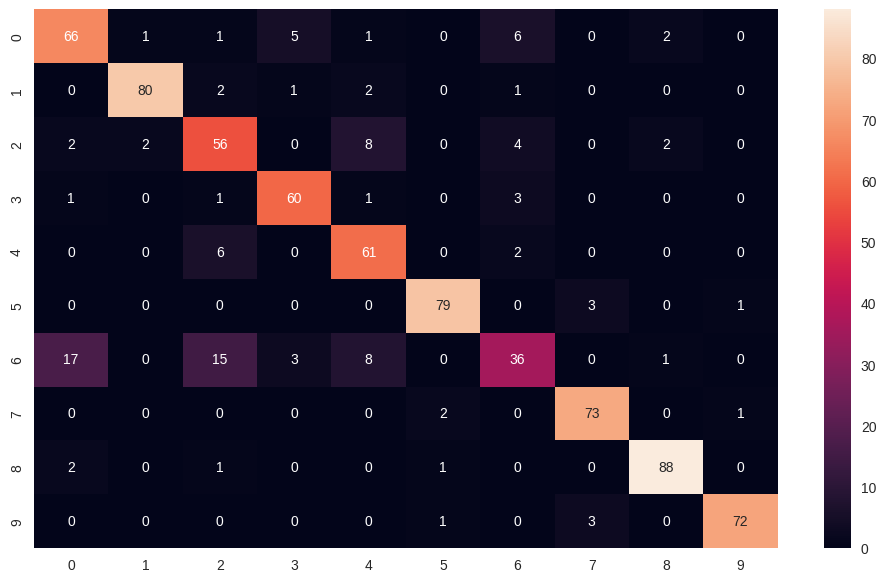

In [ ]:
n_correct = 0
with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar:
        imgs = imgs.to(device)
        true_labels = labels.to(device)

        flattened_imgs = imgs.flatten(start_dim=1)
        model.eval()
        preds = model(flattened_imgs)

        pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
        cur_correct = len(torch.where(pred_labels == true_labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(true_labels.cpu().numpy(), pred_labels.cpu().numpy())
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)
plt.savefig('output.png')



In [ ]:
def get_mnist(batch_size):
  # BATCH_SIZE = 1024
  train_loader =  torch.utils.data.DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          shuffle=True
      )

  eval_loader =  torch.utils.data.DataLoader(
          dataset=test_dataset,
          batch_size=batch_size,
          shuffle=False
      )
  return train_loader, eval_loader


In [ ]:
CLASSES = 10
def define_model(trial):
    # optimize the number of layers
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    input_dim = 28 * 28
    # for each layer ,optimize its number of units, dropout
    for i in range(n_layers):
        output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(input_dim, output_dim))
        layers.append(nn.ReLU())
        dropout_prob = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(dropout_prob))

        input_dim = output_dim
    layers.append(nn.Linear(input_dim, CLASSES))
    # layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

In [ ]:

def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    #optimizers hyperparamters Suggesitions
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    # generate the optimizer
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    #Suggest batch size
    batch_size = trial.suggest_int("batch_size", 32, 256, step=32)

    N_TRAIN_EXAMPLES =  batch_size *30
    N_VALID_EXAMPLES = batch_size * 10
    # Get the FashionMNIST dataset with the suggessted batch_size
    train_loader, valid_loader = get_mnist(batch_size)

    #suggest epochs number
    num_epochs = trial.suggest_int("epochs", 5, 50)

    # Training of the model
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, labels) in enumerate(train_loader):
            # # Limiting validation data.
            if batch_idx * batch_size >= N_TRAIN_EXAMPLES:
                break

            data, labels = data.view(data.size(0), -1).to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(valid_loader):
                # # Limiting validation data.
                if batch_idx * batch_size >= N_VALID_EXAMPLES:
                    break
                data, labels = data.view(data.size(0), -1).to(device), labels.to(device)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2024-10-21 00:21:45,589] A new study created in memory with name: no-name-7f5f02d3-b7f8-4898-81a2-787362833c90
[I 2024-10-21 00:22:04,646] Trial 0 finished with value: 0.06875 and parameters: {'n_layers': 2, 'n_units_l0': 60, 'dropout_l0': 0.3175922050434881, 'n_units_l1': 103, 'dropout_l1': 0.20762811694493072, 'optimizer': 'SGD', 'lr': 3.5421252949314494e-05, 'batch_size': 96, 'epochs': 32}. Best is trial 0 with value: 0.06875.
[I 2024-10-21 00:22:17,461] Trial 1 finished with value: 0.7484375 and parameters: {'n_layers': 2, 'n_units_l0': 39, 'dropout_l0': 0.28595290477168345, 'n_units_l1': 122, 'dropout_l1': 0.23504716102800235, 'optimizer': 'RMSprop', 'lr': 0.0001359497463666686, 'batch_size': 64, 'epochs': 30}. Best is trial 1 with value: 0.7484375.
[I 2024-10-21 00:22:37,702] Trial 2 finished with value: 0.45535714285714285 and parameters: {'n_layers': 1, 'n_units_l0': 38, 'dropout_l0': 0.29798085271394387, 'optimizer': 'SGD', 'lr': 0.002381376747220107, 'batch_size': 224, 'ep

In [ ]:
from optuna.visualization import *
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
# best trial
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Value:  0.8651041666666667
  Params: 
    n_layers: 1
    n_units_l0: 109
    dropout_l0: 0.4473833016007681
    optimizer: RMSprop
    lr: 0.000609519197198615
    batch_size: 192
    epochs: 48
